# Logisitic smooth regression model

Following van der Wiel et al. 2019, let's model energy demand using a logistic smooth regression model: https://www.sciencedirect.com/science/article/pii/S1364032119302862

This takes a single predictor, daily mean temperature, and provides a smooth transition between two linear regimes.

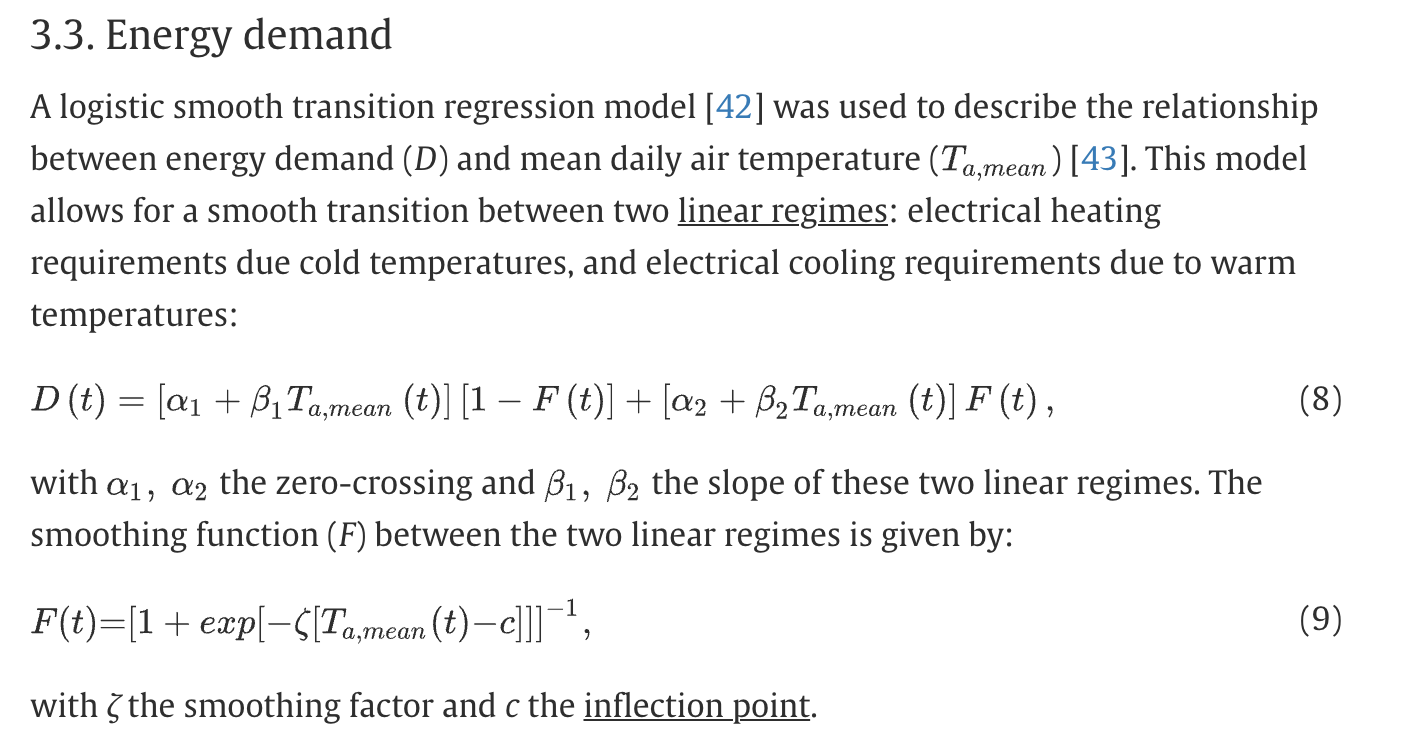

In [14]:
import xarray as xr
import numpy as np

from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

from scipy.stats import spearmanr, pearsonr

import matplotlib.pyplot as plt

In [15]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predictand)

In [18]:
aus_dem = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

In [19]:
eu_dem = xr.open_dataset(
    path + "data/energy_demand/EU_daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

Less demand on weekends

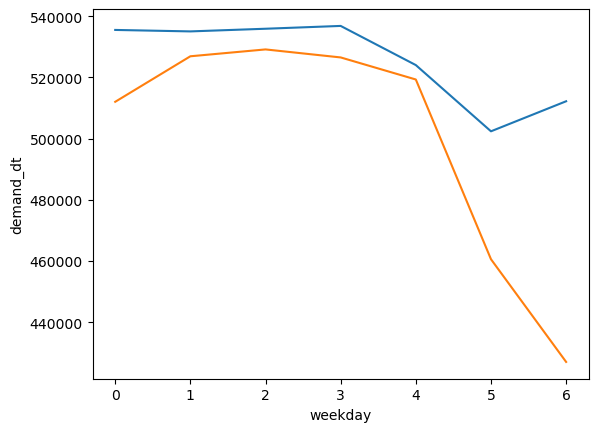

In [56]:
aus_dem.sel(region="NEM").groupby("time.weekday").mean().plot()
eu_dem.groupby("time.weekday").mean().plot()

Some studies remove August from Europe demand as its a big holiday month. Nothing equivalent evident for NEM?

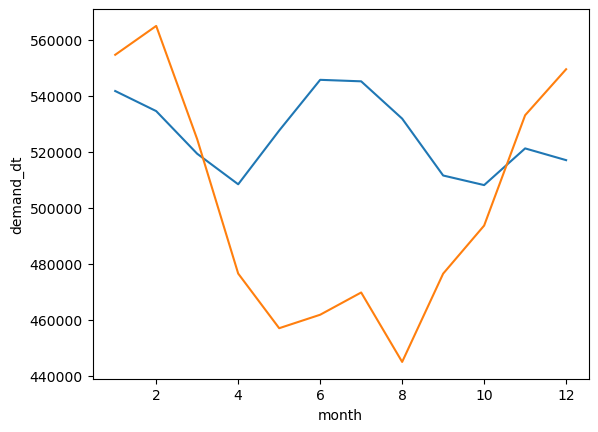

In [57]:
aus_dem.sel(region="NEM").groupby("time.month").mean().plot()
eu_dem.groupby("time.month").mean().plot()

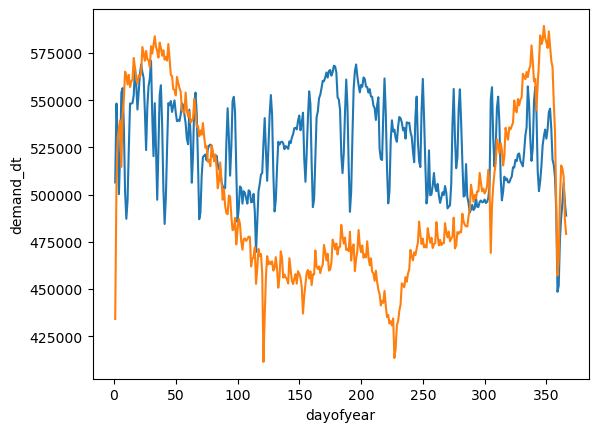

In [ ]:
aus_dem.sel(region="NEM").groupby("time.dayofyear").mean().plot()
eu_dem.groupby("time.dayofyear").mean().plot()

Functions to exclude dates

In [59]:
def rm_weekend(da):
    """
    Set weekend days to NaN
    """
    return da.where(da.time.dt.dayofweek < 5)

In [60]:
def rm_month(da, month):
    """
    Set a particular month to NaN
    """
    return da.where(da.time.dt.month != month)

In [61]:
def rm_xmas(da):
    """
    Set 21/12 through 06/01 to NaN
    """
    da_ = da.where(
        da.where(
            (da.time.dt.month == 12) & 
            (da.time.dt.day > 20)
        ).isnull()
    )
    da_ = da_.where(
        da_.where(
            (da_.time.dt.month == 1) & 
            (da_.time.dt.day < 7)
        ).isnull()
    )
    return da_

In [80]:
def rm_nan(x):
    """
    Remove NaNs from array
    """
    return x[~np.isnan(x)]

Daily mean temperature

In [20]:
aus_t2m = xr.open_dataset(path + "demand_predictors/2t_era5_daily_1959-2022_NEM.nc")["t2m"]

In [21]:
eu_t2m = xr.open_dataset(path + "demand_predictors/2t_era5_daily_1959-2022_EU.nc")["t2m"]

# Model fitting functions

In [16]:
def lstr(x, a1, a2, b1, b2, z, c):
    """
    Logistic smooth transition equation
    """
    F = 1 / (1 + np.exp(-z * (x - c)))
    term1 = (a1 + b1 * x) * (1 - F)
    term2 = (a2 + b2 * x) * F
    return term1 + term2

In [17]:
def fit_model(xda, yda, inits):
    """
    Fit logistic smooth transition regression to data.
    """
    x = xda.values
    y = yda.values
    
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    params, _ = curve_fit(lstr, x, y, p0=inits, maxfev=25000)
    return params

# Scores

In [68]:
def compute_scores(y_true, y_pred, metrics):
    """
    Compute scores for a variety of metrics, plus pearson and spearman correlation.
    
    y_true: observations
    y_predict: predictions
    metrics: list of scores from sklearn.metrics
    """
    scores = []
    for metric in metrics:
        s = metric(y_true, y_pred)
        scores.append(s)
    cor_p, _ = pearsonr(y_true, y_pred)
    cor_s, _ = spearmanr(y_true, y_pred)
    scores.append(cor_p)
    scores.append(cor_s)
    return scores

# NEM model

In [105]:
def plot_time_remove_scores(x, y, month, inits):
    """
    Bar plot of MAE and r, comparing scores on all data,
    and data with some aspects removed (e.g. weekends)
    """
    def mae_cor(x, y):
        a1, a2, b1, b2, z, c = fit_model(x, y, inits=inits)
        pred = lstr(x.values, a1, a2, b1, b2, z, c)
        y = rm_nan(y)
        pred = rm_nan(pred)
        return compute_scores(y, pred, [mean_absolute_error])[:2]

    mae = []
    cor = []
    
    m, c = mae_cor(x, y)
    mae.append(m)
    cor.append(c)

    x_ = rm_weekend(x)
    y_ = rm_weekend(y)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)

    x_ = rm_month(x, month)
    y_ = rm_month(y, month)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)

    x_ = rm_xmas(x)
    y_ = rm_xmas(y)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)

    x_ = rm_weekend(x)
    x_ = rm_xmas(x_)
    y_ = rm_weekend(y)
    y_ = rm_xmas(y_)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)

    x_ = rm_weekend(x)
    x_ = rm_xmas(x_)
    x_ = rm_month(x_, 8)
    y_ = rm_weekend(y)
    y_ = rm_month(y_, 8)
    y_ = rm_xmas(y_)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)
    
    fig, ax = plt.subplots(2, 1)
    xlabels = ["None", "Wknd", "Month "+str(month), "Xmas", "Wknd+Xmas", "All"]
    ax[0].bar(xlabels, mae)
    ax[0].set_ylabel("MAE")
    ax[1].bar(xlabels, cor)
    ax[1].set_ylabel("Pearson r")

In [107]:
def plot_fit(ax, x_scatter, y_scatter, x_fit, y_fit, title):
    """
    Scatter plot of demand vs temperature with model fit line
    """
    ax.scatter(x_scatter, y_scatter, alpha=0.3, s=10)
    ax.plot(x_fit, y_fit, color="r")
    ax.set_xlabel("Temperature [deg C]")
    ax.set_ylabel("Demand [GWh/day]")
    ax.set_title(title)

In [108]:
def plot_ts(ax, x1, x2, title):
    """
    Timeseries and fit stats
    """
    ax.plot(x1, lw=0.7)
    ax.plot(x2, lw=0.8)
    ax.set_xlabel("Time [day]")
    ax.set_ylabel("Demand [GWh/day]")
    ax.set_title(title)

Need to guess starting parameter values otherwise fitting will fail

In [109]:
aus_init = [-6e6, -4e3, 2e3, 2e1, 0.2, 0]

Model performance with time removed

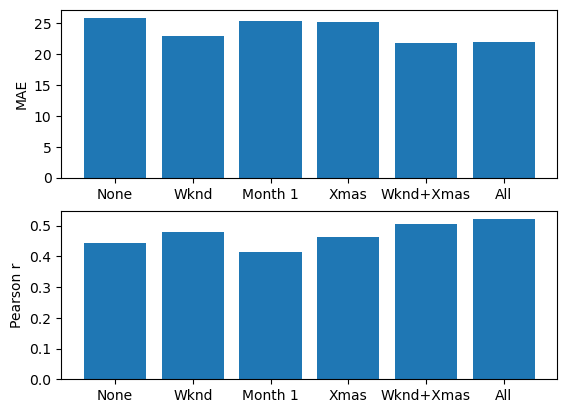

In [119]:
plot_time_remove_scores(
    aus_t2m.sel(region="NEM", time=aus_dem["time"]) - 273.15,
    aus_dem.sel(region="NEM") / 1000,
    1,
    aus_init
)

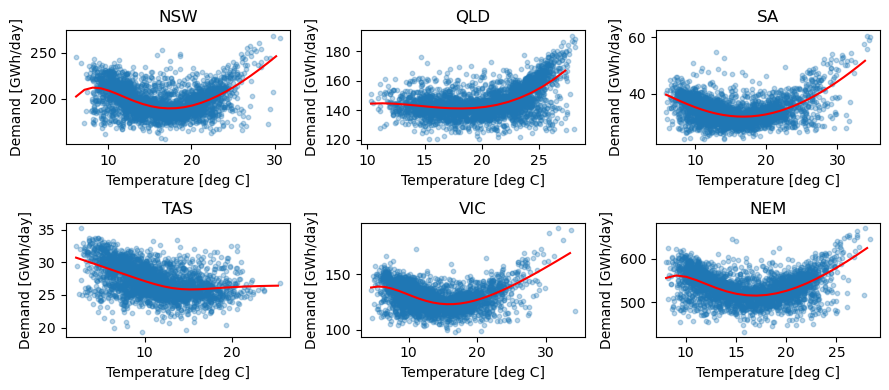

In [120]:
fig, ax = plt.subplots(2, 3, figsize=(9,4))
for i, region in enumerate(aus_dem["region"].values):
    
    t = aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15
    d = aus_dem.sel(region=region) / 1000
    
    t = rm_weekend(t)
    t = rm_xmas(t)
    t = rm_nan(t)
    d = rm_weekend(d)
    d = rm_xmas(d)
    d = rm_nan(d)
    
    a1, a2, b1, b2, z, c = fit_model(t, d, inits=init)
    x_line = np.arange(min(t.values), max(t.values), 1)
    y_line = lstr(x_line, a1, a2, b1, b2, z, c)
    
    a = ax.flatten()[i]
    plot_fit(a, t, d, x_line, y_line, region)
plt.tight_layout()

In [65]:
metrics = [mean_absolute_error]
metric_names = ["MAE", "Pearson cor", "Spearman cor"]

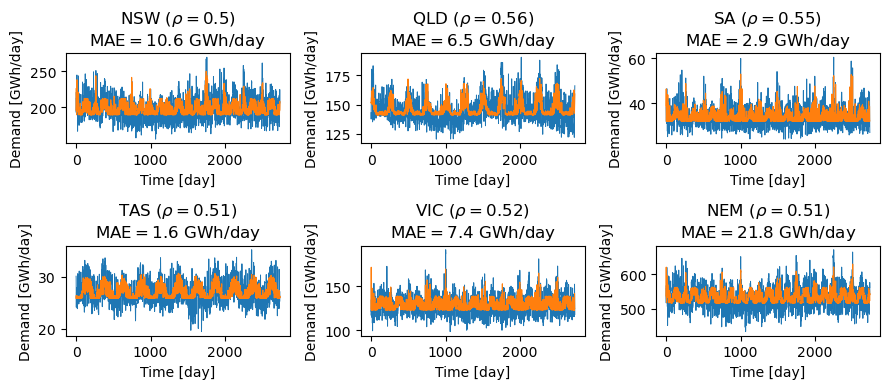

In [121]:
fig, ax = plt.subplots(2, 3, figsize=(9,4))
for i, region in enumerate(aus_dem["region"].values):
    
    t = aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15
    d = aus_dem.sel(region=region) / 1000
    
    t = rm_weekend(t)
    t = rm_xmas(t)
    t = rm_nan(t)
    d = rm_weekend(d)
    d = rm_xmas(d)
    d = rm_nan(d)
    
    a1, a2, b1, b2, z, c = fit_model(t, d, inits=init)
    pred = lstr(t.values, a1, a2, b1, b2, z, c)
    
    mae, cor, _ = compute_scores(d, pred, metrics)
    # cor, _ = np.round(pearsonr(d, pred), 2)
    # # rmse = np.round(np.sqrt(mean_squared_error(d, pred)), 2)
    # mae = np.round(mean_absolute_error(d, pred), 2)
    
    title = region + r" ($\rho=$"+str(np.round(cor, 2)) + ")\n" + r"MAE$=$" + str(np.round(mae, 1)) + " GWh/day"
    a = ax.flatten()[i]
    plot_ts(a, d, pred, title)
plt.tight_layout()

### Europe

In [97]:
eu_init = [500, 300, -2, 2, 0.5, 10]

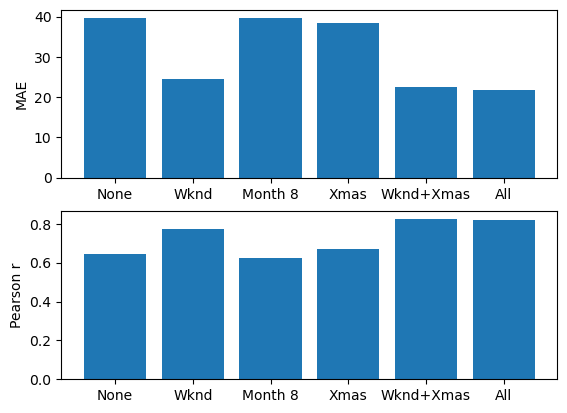

In [122]:
plot_time_remove_scores(
    eu_t2m.sel(time=eu_dem.time) - 273.15,
    eu_dem / 1000,
    8,
    eu_init
)

606.4119091392242 -2.09311698862845 442.2768019409953 2.183199242826928 0.40417236896942194 9.276813899690511


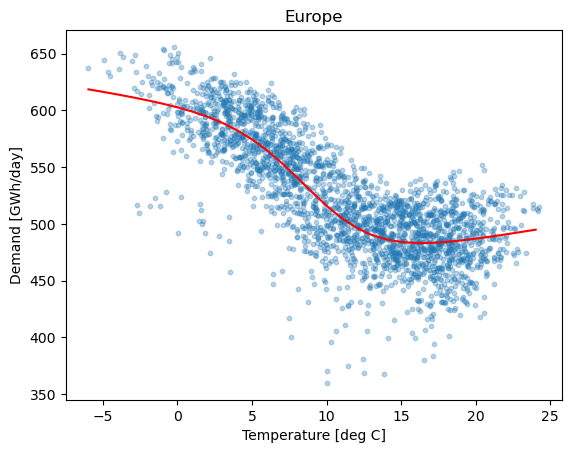

In [123]:
fig, ax = plt.subplots()
    
t = eu_t2m.sel(time=eu_dem["time"]) - 273.15
d = eu_dem / 1000

t = rm_weekend(t)
t = rm_xmas(t)
t = rm_nan(t)
d = rm_weekend(d)
d = rm_xmas(d)
d = rm_nan(d)

a1, a2, b1, b2, z, c = fit_model(t, d, inits=init)
print(a1, b1, a2, b2, z, c)
x_line = np.arange(np.nanmin(t.values), np.nanmax(t.values), 1)
y_line = lstr(x_line, a1, a2, b1, b2, z, c)

plot_fit(ax, t, d, x_line, y_line, "Europe")

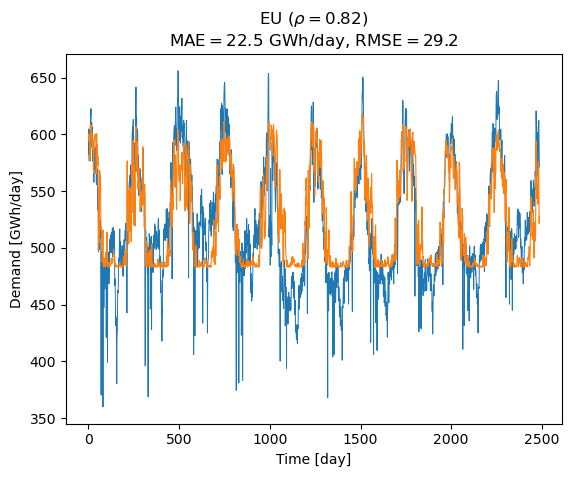

In [126]:
fig, ax = plt.subplots()
    
t = eu_t2m.sel(time=eu_dem["time"]) - 273.15
d = eu_dem / 1000

t = rm_weekend(t)
t = rm_xmas(t)
t = rm_nan(t)
d = rm_weekend(d)
d = rm_xmas(d)
d = rm_nan(d)

a1, a2, b1, b2, z, c = fit_model(t, d, inits=init)
pred = lstr(t.values, a1, a2, b1, b2, z, c)

mae, cor, _ = compute_scores(d, pred, metrics)
rmse = np.sqrt(mean_squared_error(d, pred))

title = "EU" + r" ($\rho=$"+str(np.round(cor, 2)) + ")\n" + r"MAE$=$" + str(np.round(mae, 1)) + " GWh/day, RMSE$=$" + str(np.round(rmse, 1))
plot_ts(ax, d, pred, title)